# Database Systems Project

#### Group: Maxim Daniel, Mathias Husted

For this project, we have been given 2 datasets `hochschulen.csv` and `bevoelkerung.csv` to analyze. We have to complete 8 separate tasks, including pitching an idea for ways to analyze the dataset, preprocessing the data, performing queries on it and visualize our results. We will be using PostgreSQL with the Python framework psycopg.

Let's start with the imports!

In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

For this project, we'll be using a Conda environment to manage Python (+ dependencies) as well as the Postgres server itself

## Task 1 (Project idea)

1) Have a look at the data sets hochschulen.csv and bevoelkerung.csv
2) Conceptualize a data visualization that integrates and effectively presents information from
the given datasets. Prepare a brief written description of your project goal.

Let's start by having a look at the data

In [2]:
# We'll use pandas to read the csv files so we can see what's going on before we start:
hochschulen = pd.read_csv("hochschulen.csv", sep=";")
hochschulen.head()

,Hochschulkurzname,Hochschulname,Hochschultyp,Trägerschaft,Bundesland,Anzahl Studierende,Gründungsjahr,Promotionsrecht,Habilitationsrecht,Straße,Postleitzahl (Hausanschrift),Ort (Hausanschrift),Home Page
0,Aachen FH,Fachhochschule Aachen,Fachhochschulen / HAW,öffentlich-rechtlich,Nordrhein-Westfalen,14086,1971,Nein,Nein,Bayernallee 11,52066.0,Aachen,http://www.fh-aachen.de
1,Aachen TH,Rheinisch-Westfälische Technische Hochschule A...,Universitäten,öffentlich-rechtlich,Nordrhein-Westfalen,45527,1870,Ja,Ja,Templergraben 55,52062.0,Aachen,https://www.rwth-aachen.de
2,Aalen H,Hochschule Aalen - Technik und Wirtschaft,Fachhochschulen / HAW,öffentlich-rechtlich,Baden-Württemberg,4559,1962,Nein,Nein,Beethovenstraße 1,73430.0,Aalen,http://www.hs-aalen.de
3,Albstadt-Sigmaringen H,Hochschule Albstadt-Sigmaringen,Fachhochschulen / HAW,öffentlich-rechtlich,Baden-Württemberg,2666,1971,Nein,Nein,Anton-Günther-Straße 51,72488.0,Sigmaringen,www.hs-albsig.de
4,Alfter HfKuG,Alanus Hochschule für Kunst und Gesellschaft,Künstlerische Hochschulen,"privat, staatlich anerkannt",Nordrhein-Westfalen,1564,1973,Ja,Nein,Villestraße 3,53347.0,Alfter,https://www.alanus.edu/de/home


That looks alright for now, now let's try loading the other dataset

In [3]:
bevoelkerung = pd.read_csv("bevoelkerung.csv", sep=";", encoding='ISO-8859-1')
bevoelkerung.head()

,,,,GENESIS-Tabelle: 12411-01-01-4
Bevölkerung nach Geschlecht - Stichtag 31.12. - regionale,NaN,NaN,NaN,NaN
Tiefe: Kreise und krfr. Städte,NaN,NaN,NaN,NaN
Fortschreibung des Bevölkerungsstandes,NaN,NaN,NaN,NaN
Bevölkerungsstand (Anzahl),NaN,NaN,NaN,NaN
NaN,NaN,Stichtag,Stichtag,Stichtag


We have some general information at the top of the table with some metadata. We're not interested in that, so let's try and skip it

In [4]:
bevoelkerung = pd.read_csv("bevoelkerung.csv", sep=";", encoding='ISO-8859-1', skiprows=7)
bevoelkerung.head()

,Unnamed: 0,Unnamed: 1,Insgesamt,männlich,weiblich
0,DG,Deutschland,84358845,41559052,42799793
1,01,Schleswig-Holstein,2953270,1443269,1510001
2,01001,"Flensburg, kreisfreie Stadt",92550,45874,46676
3,01002,"Kiel, kreisfreie Stadt",247717,120149,127568
4,01003,"Lübeck, kreisfreie Stadt, Hansestadt",218095,104723,113372


Alright, that's definitely a mess. That will need some cleaning up, which we'll do for task 3.

Now, let's continue with the visualizations. For the first plot we will show the top 10 universities in Germany by no. of students:

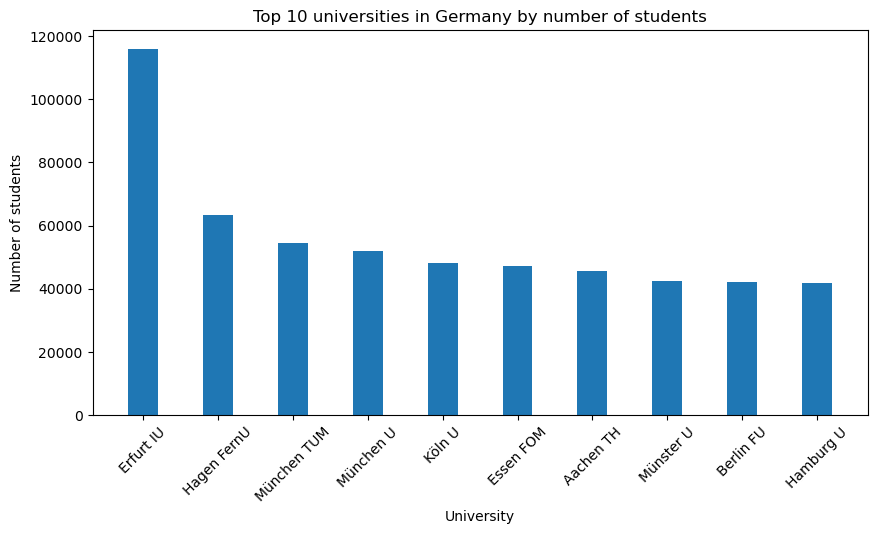

In [5]:
# Hochschulen
hochschulen['Anzahl Studierende'] = pd.to_numeric(hochschulen['Anzahl Studierende'], errors='coerce') # Represent the row as a number

top_unis = hochschulen.dropna(subset=['Anzahl Studierende'])
top_unis = top_unis.sort_values(['Anzahl Studierende'], ascending=False).head(10)

fig = plt.figure(figsize=(10,5))

plt.bar(top_unis['Hochschulkurzname'], top_unis['Anzahl Studierende'], width=0.4)
plt.title("Top 10 universities in Germany by number of students")
plt.ylabel("Number of students")
plt.xlabel("University")
plt.xticks(rotation=45)
plt.show()

For the population dataset, we will need to do data cleaning before we can represent it graphically.

**Project goal:** For our project, our goal is to
1) Find out which federal states have the most universities and students per capita
2) Find out correlations between the founding year of a university and its number of students
3) Visualize gender differences in the population in built up vs. rural areas of Germany
4) Find out the popularity differences between universities and universities of applied sciences (Fachhochschulen) as well as public vs. private universities
5) Find out proportions of students in cities' populations

## Task 2 (Data schema and database set up)

1) Identify the relevant data fields for analysis and visualization.
2) Draw an Entity-Relationship model (ERM) for the datasets.
3) Transform the ERM into a relational model.
4) Set up a PostgreSQL database based on the relational model.

2.1/2.2: For this project, we want to merge the two datasets into one in order to integrate the data.

We started based on the following ER model:

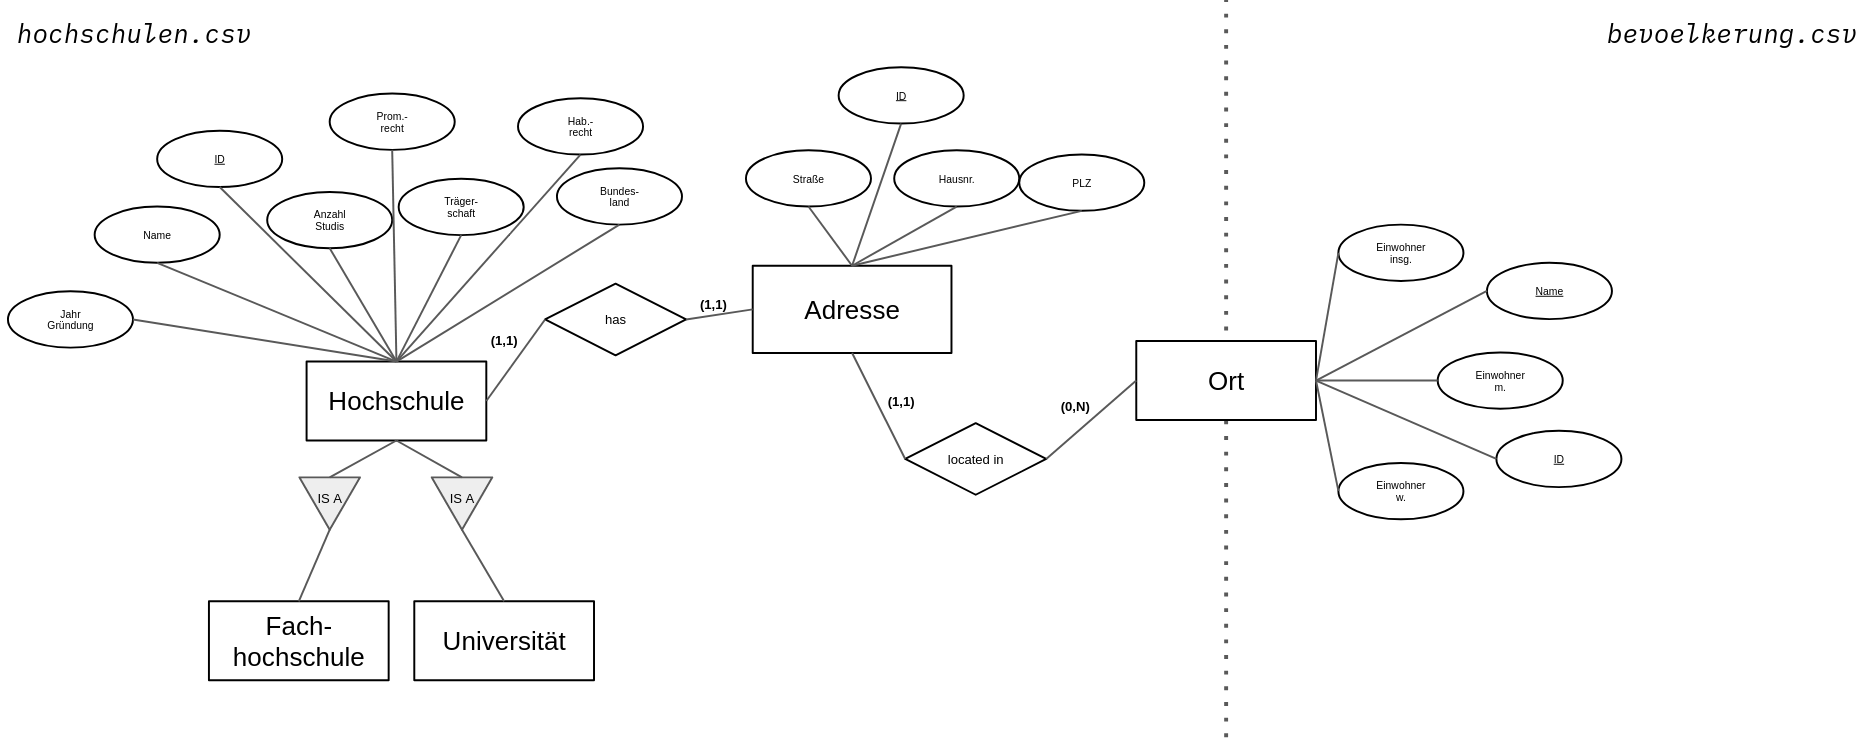

after some optimizations we ended up with this:
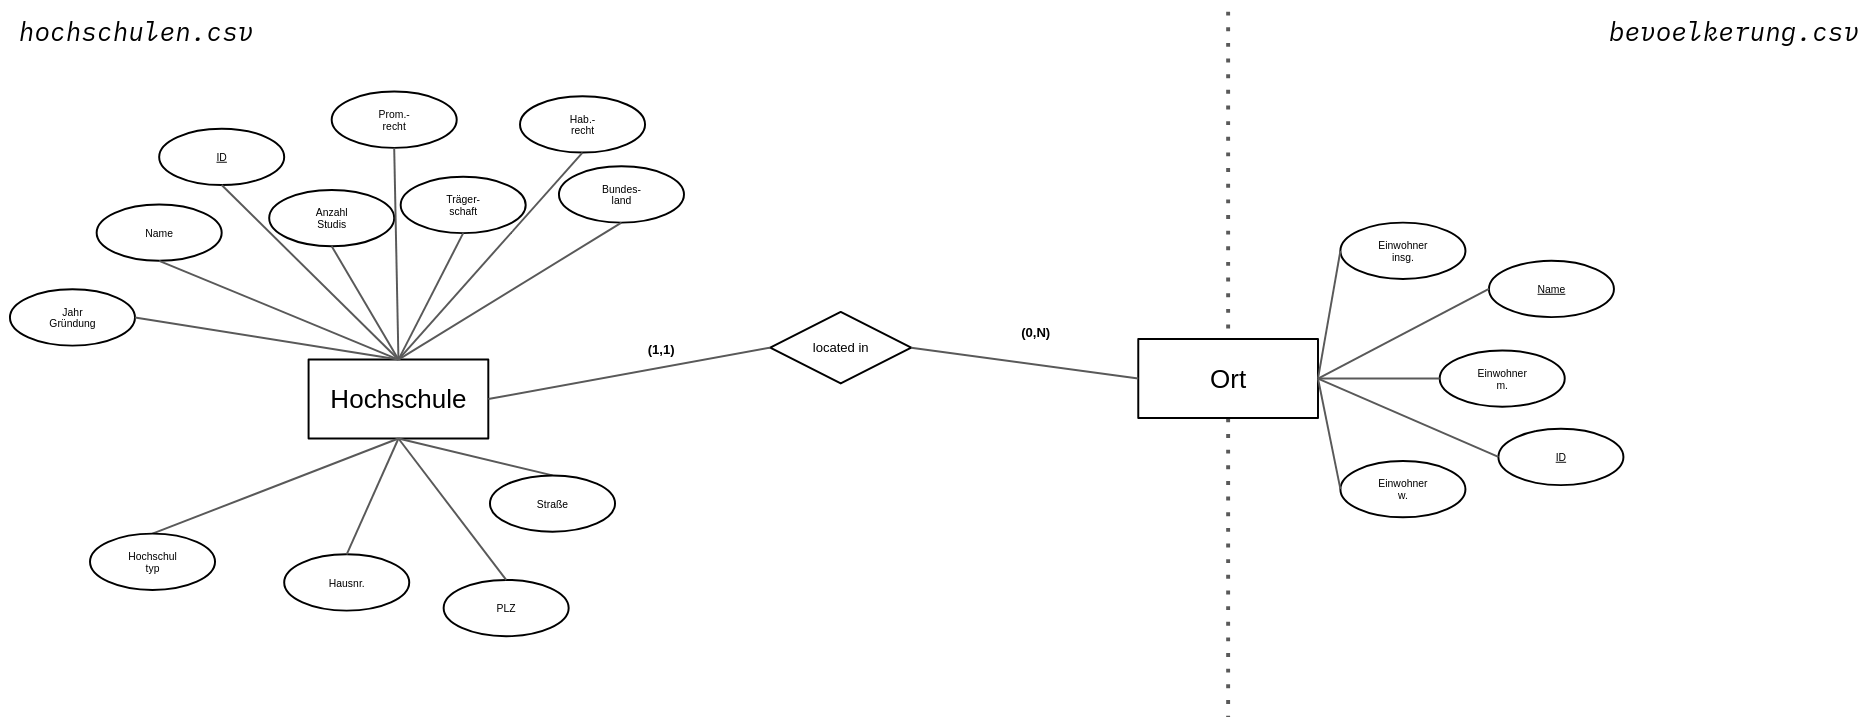

which better unifies the two datasets.

We will merge the datasets on the `Ort` attribute

2.3: Relational model (transformed from the ER model **with some improvements**)

**Schema:**

Hochschule(<ins>ID</ins>, <span style="border-bottom: 1px dotted #000;">OrtID</span>, Name, JahrGr, AnzahlStud, PromR, HabR, Traegerschaft, Bundesland, Hochschultyp, Strasse, PLZ)

Ort(<ins>OrtID</ins>, Name, EinwohnerM, EinwohnerW, EinwohnerIns)

2.4: Let's set up the database:

We run `initdb -D project` to set up a Postgres database for our project

Then, we can run `pg_ctl -D project -l logfile start` to start the server

Afterwards we create our database by running the following from the PostgreSQL terminal

To open the PostgreSQL terminal we use:

```bash
psql -U <local_username> postgres # local_username is your username you use to log into your Linux system
```

Now, we can execute commands in the terminal

```sql
-- Create a new database
CREATE DATABASE hochschule_db;

-- Create a new user
CREATE USER hochschule_user WITH PASSWORD 'password';

-- Grant all privileges on the new database to the new user
GRANT ALL PRIVILEGES ON SCHEMA public TO hochschule_user;
GRANT ALL PRIVILEGES ON DATABASE hochschule_db TO hochschule_user;

-- Exit the PostgreSQL prompt
\q
```

To access the terminal from now on (if we want to make modifications directly from there), we use the following command:

```bash
psql -U <local_username> hochschule_db
```

Finally, let's create our schema:

In [6]:
try:
    conn = psycopg2.connect(
        dbname="hochschule_db",
        user="hochschule_user",
        password="password",
        host="localhost",
        port="5432"
    )
except:
    print("Couldn't connect to the database")




cur = conn.cursor()



# Define the schema

create_ort_table = """
CREATE TABLE IF NOT EXISTS Ort (
    OrtID SERIAL PRIMARY KEY,
    Name VARCHAR(255) NOT NULL,
    EinwohnerM INTEGER,
    EinwohnerW INTEGER,
    EinwohnerIns INTEGER
);
"""

create_hochschule_table = """
CREATE TABLE IF NOT EXISTS Hochschule (
    ID SERIAL PRIMARY KEY,
    Name VARCHAR(255) NOT NULL,
    JahrGr INTEGER,
    AnzahlStud INTEGER,
    PromR BOOLEAN,
    HabR BOOLEAN,
    Traegerschaft VARCHAR(255),
    Bundesland VARCHAR(255),
    Hochschultyp VARCHAR(255),
    OrtID INTEGER REFERENCES Ort(OrtID),
    Strasse VARCHAR(255),
    PLZ VARCHAR(20)
);
"""

cur.execute(create_ort_table)
cur.execute(create_hochschule_table)

conn.commit()

cur.close()
conn.close()

print("Created schema if it did not already exist")

Created schema if it did not already exist


## Task 3 (Data pre-processing and import)
1. Pre-process (data cleansing) the data sets.
2. Import the data sets into the created database.

For `hochschulen.csv`, our data is sufficiently good so that we can clean it using pandas:

In [7]:
hochschulen = pd.read_csv("hochschulen.csv", sep=";")

# First, read the number of students as an integer
hochschulen['Anzahl Studierende'] = pd.to_numeric(hochschulen['Anzahl Studierende'], errors='coerce')

# Remove empty cells
hochschulen = hochschulen.dropna()

hochschulen.to_csv('hochschulen_clean.csv', index=False)

For `bevoelkerung.csv`, it is a little bit more complicated, let's have a look:

In [8]:
bevoelkerung = pd.read_csv("bevoelkerung.csv", sep=";", encoding='ISO-8859-1', skiprows=7)

bevoelkerung.drop(bevoelkerung.tail(4).index,inplace=True) # Last 4 rows are not data

pd.set_option("min_rows", 200)

bevoelkerung

,Unnamed: 0,Unnamed: 1,Insgesamt,männlich,weiblich
0,DG,Deutschland,84358845,41559052,42799793
1,01,Schleswig-Holstein,2953270,1443269,1510001
2,01001,"Flensburg, kreisfreie Stadt",92550,45874,46676
3,01002,"Kiel, kreisfreie Stadt",247717,120149,127568
4,01003,"Lübeck, kreisfreie Stadt, Hansestadt",218095,104723,113372
5,01004,"Neumünster, kreisfreie Stadt",79502,39256,40246
6,01051,"Dithmarschen, Kreis",135252,66561,68691
7,01053,"Herzogtum Lauenburg, Kreis",203712,99689,104023
8,01054,"Nordfriesland, Kreis",169043,82669,86374
9,01055,"Ostholstein, Kreis",203606,97822,105784


Our data starts from the 8th row and onwards. This means that we can take this as a starting point.

The observation we make is that the row `Unnamed: 1` is representative of the location. This can be either Germany as a whole, a municipality or a city. We can sort our data using pandas by using the patterns from `Unnamed: 0` to divide our data into subsets:

In [9]:
# Population for the entire country is in the first row
bev_deutschland = bevoelkerung.iloc[0]

# Now, we can drop the first row which we have now saved and interpret the rest of the ID's as numeric values
bevoelkerung.drop(bevoelkerung.head(1).index,inplace=True)

# Let's rename the columns to make them readable
bevoelkerung = bevoelkerung.rename(columns={"Unnamed: 0": "ID", "Unnamed: 1": "Ort"})

# Make the population sizes numeric
bevoelkerung['Insgesamt'] = pd.to_numeric(bevoelkerung['Insgesamt'], errors='coerce')
bevoelkerung['männlich'] = pd.to_numeric(bevoelkerung['männlich'], errors='coerce')
bevoelkerung['weiblich'] = pd.to_numeric(bevoelkerung['weiblich'], errors='coerce')
bevoelkerung['ID'] = pd.to_numeric(bevoelkerung['ID'], errors='coerce')

# Remove rows with missing information
bevoelkerung = bevoelkerung.dropna()

In [10]:
# Now let's export the clean data
bevoelkerung.to_csv('bevoelkerung_clean.csv', index=False)

It is obvious from the data that rows in which the ID is between 1 and 16 represents the federal states, and the rest are cities and municipalities. Let's check if that holds true:

In [11]:
bev_bundesland = bevoelkerung[bevoelkerung['ID'] <= 16]

bev_bundesland

,ID,Ort,Insgesamt,männlich,weiblich
1,1,Schleswig-Holstein,2953270.0,1443269.0,1510001.0
17,2,Hamburg,1892122.0,925616.0,966506.0
18,3,Niedersachsen,8140242.0,4009822.0,4130420.0
71,4,Bremen,684864.0,338233.0,346631.0
74,5,Nordrhein-Westfalen,18139116.0,8890200.0,9248916.0
135,6,Hessen,6391360.0,3151158.0,3240202.0
165,7,Rheinland-Pfalz,4159150.0,2054254.0,2104896.0
205,8,Baden-Württemberg,11280257.0,5595424.0,5684833.0
254,9,Bayern,13369393.0,6620203.0,6749190.0
358,10,Saarland,992666.0,487101.0,505565.0


Great! We will remember for the data analysis that certain types of regions (states, municipalities, cities) are encoded in different lengths of digits.

To avoid conflicts with cities/city states (i.e. Brandenburg vs. Brandenburg an der Havel, Bremen vs. Bremerhaven), let's remove these from the dataset so we can avoid massively inflated population sizes for those cities in our database:

In [12]:
bevoelkerung = bevoelkerung[bevoelkerung['ID'] > 16]

Let's do one last check of the first 10 rows before we insert it:

In [13]:
for index, row in bevoelkerung.iterrows():
    print(f"ID: {row['ID']}, Name: {row['Ort']}, männlich: {row['männlich']}, weiblich: {row['weiblich']}\n")
    if index == 10:
        break

ID: 1001, Name:       Flensburg, kreisfreie Stadt, männlich: 45874.0, weiblich: 46676.0

ID: 1002, Name:       Kiel, kreisfreie Stadt, männlich: 120149.0, weiblich: 127568.0

ID: 1003, Name:       Lübeck, kreisfreie Stadt, Hansestadt, männlich: 104723.0, weiblich: 113372.0

ID: 1004, Name:       Neumünster, kreisfreie Stadt, männlich: 39256.0, weiblich: 40246.0

ID: 1051, Name:       Dithmarschen, Kreis, männlich: 66561.0, weiblich: 68691.0

ID: 1053, Name:       Herzogtum Lauenburg, Kreis, männlich: 99689.0, weiblich: 104023.0

ID: 1054, Name:       Nordfriesland, Kreis, männlich: 82669.0, weiblich: 86374.0

ID: 1055, Name:       Ostholstein, Kreis, männlich: 97822.0, weiblich: 105784.0

ID: 1056, Name:       Pinneberg, Kreis, männlich: 157663.0, weiblich: 164467.0



It looks like there are some useless leading spaces in our data. Let's fix that up first and then insert it into the database 

In [14]:
bevoelkerung['Ort'] = bevoelkerung['Ort'].str.strip()

In [15]:
# Last check
for index, row in bevoelkerung.iterrows():
    print(f"ID: {row['ID']}, Name: {row['Ort']}, männlich: {row['männlich']}, weiblich: {row['weiblich']}\n")
    if index == 5:
        break

ID: 1001, Name: Flensburg, kreisfreie Stadt, männlich: 45874.0, weiblich: 46676.0

ID: 1002, Name: Kiel, kreisfreie Stadt, männlich: 120149.0, weiblich: 127568.0

ID: 1003, Name: Lübeck, kreisfreie Stadt, Hansestadt, männlich: 104723.0, weiblich: 113372.0

ID: 1004, Name: Neumünster, kreisfreie Stadt, männlich: 39256.0, weiblich: 40246.0



Let's now insert the data

In [16]:
'''
Schema for ort:
OrtID SERIAL PRIMARY KEY,
Name VARCHAR(255) NOT NULL,
EinwohnerM INTEGER,
EinwohnerW INTEGER,
EinwohnerIns INTEGER
'''

try:
    conn = psycopg2.connect(
        dbname="hochschule_db",
        user="hochschule_user",
        password="password",
        host="localhost",
        port="5432"
    )
except psycopg2.OperationalError as e:
    print("Couldn't connect to the database")
    print(e)
    conn = None

if conn:
    cur = conn.cursor()
    
    for index, row in bevoelkerung.iterrows():
        if index == 1:
            print("Starting...")
        try:
            cur.execute(
                """
                INSERT INTO Ort (OrtID, Name, EinwohnerM, EinwohnerW, EinwohnerIns)
                VALUES (%s, %s, %s, %s, %s)
                ON CONFLICT (OrtID) DO NOTHING
                """,
                (row['ID'], row['Ort'], row['männlich'], row['weiblich'], row['Insgesamt'])
            )
        except psycopg2.Error as e:
            print(f"Error inserting row {index}: {e}")
            
    print("Finished!")

    conn.commit()
    cur.close()
    conn.close()

Finished!


Now, when we execute
```bash
TABLE ort;
```

within our psql terminal, it should return all of the data from our bevoelkerung dataset within the database like this:

```
  ortid   |                      name                       | einwohnerm | einwohnerw | einwohnerins 
----------+-------------------------------------------------+------------+------------+--------------
        1 | Schleswig-Holstein                              |    1443269 |    1510001 |      2953270
     1001 | Flensburg, kreisfreie Stadt                     |      45874 |      46676 |        92550
     1002 | Kiel, kreisfreie Stadt                          |     120149 |     127568 |       247717
     1003 | Lübeck, kreisfreie Stadt, Hansestadt            |     104723 |     113372 |       218095
     1004 | Neumünster, kreisfreie Stadt                    |      39256 |      40246 |        79502
     1051 | Dithmarschen, Kreis                             |      66561 |      68691 |       135252
     1053 | Herzogtum Lauenburg, Kreis                      |      99689 |     104023 |       203712
     1054 | Nordfriesland, Kreis                            |      82669 |      86374 |       169043
     1055 | Ostholstein, Kreis                              |      97822 |     105784 |       203606
     1056 | Pinneberg, Kreis                                |     157663 |     164467 |       322130
     1057 | Plön, Kreis                                     |      63357 |      67909 |       131266
     1058 | Rendsburg-Eckernförde, Kreis                    |     137154 |     141825 |       278979
     1059 | Schleswig-Flensburg, Kreis                      |     101614 |     104424 |       206038
     1060 | Segeberg, Kreis                                 |     140654 |     144334 |       284988
     1061 | Steinburg, Kreis                                |      65268 |      67151 |       132419
     1062 | Stormarn, Kreis                                 |     120816 |     127157 |       247973
        2 | Hamburg                                         |     925616 |     966506 |      1892122
        3 | Niedersachsen                                   |    4009822 |    4130420 |      8140242
       31 | Braunschweig, Statistische Region               |     796058 |     814807 |      1610865
     3101 | Braunschweig, kreisfreie Stadt                  |     124770 |     127034 |       251804
     3102 | Salzgitter, kreisfreie Stadt                    |      51829 |      52719 |       104548
     3103 | Wolfsburg, kreisfreie Stadt                     |      62441 |      63520 |       125961
...
```

Now, we'll repeat the same for the Hochschule table, but first, let's check if we need to make any modifications to the data prior to inserting it:

In [17]:
# Make sure everything is in the correct data type for the schema

hochschulen.dtypes

Hochschulkurzname                object
Hochschulname                    object
Hochschultyp                     object
Trägerschaft                     object
Bundesland                       object
Anzahl Studierende              float64
Gründungsjahr                    object
Promotionsrecht                  object
Habilitationsrecht               object
Straße                           object
Postleitzahl (Hausanschrift)    float64
Ort (Hausanschrift)              object
Home Page                        object
dtype: object

We can see that we have a lot of empty spaces in some strings, and many values are in the wrong data type

In [18]:
# Remove leading and trailing spaces from string columns
hochschulen['Hochschulname'] = hochschulen['Hochschulname'].str.strip()
hochschulen['Hochschultyp'] = hochschulen['Hochschultyp'].str.strip()
hochschulen['Trägerschaft'] = hochschulen['Trägerschaft'].str.strip()
hochschulen['Bundesland'] = hochschulen['Bundesland'].str.strip()
hochschulen['Ort (Hausanschrift)'] = hochschulen['Ort (Hausanschrift)'].str.strip()

# Convert relevant fields to string type for the schema
hochschulen['Hochschulname'] = hochschulen['Hochschulname'].astype(str)
hochschulen['Hochschultyp'] = hochschulen['Hochschultyp'].astype(str)
hochschulen['Trägerschaft'] = hochschulen['Trägerschaft'].astype(str)
hochschulen['Bundesland'] = hochschulen['Bundesland'].astype(str)
hochschulen['Ort (Hausanschrift)'] = hochschulen['Ort (Hausanschrift)'].astype(str)

# Founding year as an integer
hochschulen['Gründungsjahr'] = pd.to_numeric(hochschulen['Gründungsjahr'], errors='coerce')

# Converting Anzahl Studierende to an int
hochschulen['Anzahl Studierende'] = hochschulen['Anzahl Studierende'].astype(int)
hochschulen['Postleitzahl (Hausanschrift)'] = hochschulen['Postleitzahl (Hausanschrift)'].astype(int)

In [19]:
# For PromR, HabR, we need to match the types to the correct boolean individually
hochschulen['Habilitationsrecht'] = hochschulen['Habilitationsrecht'].map({'Ja': True, 'Nein': False})
hochschulen['Promotionsrecht'] = hochschulen['Promotionsrecht'].map({'Ja': True, 'Nein': False})

In [20]:
hochschulen.dtypes

Hochschulkurzname               object
Hochschulname                   object
Hochschultyp                    object
Trägerschaft                    object
Bundesland                      object
Anzahl Studierende               int64
Gründungsjahr                    int64
Promotionsrecht                   bool
Habilitationsrecht                bool
Straße                          object
Postleitzahl (Hausanschrift)     int64
Ort (Hausanschrift)             object
Home Page                       object
dtype: object

First, we need to match all of the city names with the universities so that we can assign them their correct OrtID.

In [21]:
try:
    conn = psycopg2.connect(
        dbname="hochschule_db",
        user="hochschule_user",
        password="password",
        host="localhost",
        port="5432"
    )
except:
    print("Couldn't connect to the database")

cur = conn.cursor()

ort_ids = {}
for index, row in hochschulen.iterrows():
    ort_name = row['Ort (Hausanschrift)']
    cur.execute("SELECT OrtID FROM Ort WHERE Name LIKE %s", (f"%{ort_name}%",))
    ort_id = cur.fetchone()
    # Convert the tuples into integers
    if ort_id is None:
        ort_id = None
    elif isinstance(ort_id, tuple):
        ort_id = ort_id[0]
    if index < 10: # Only show for the first indices:
        print(f"City name: {ort_name} matched with ID: {ort_id}")
    ort_ids[ort_name] = ort_id


print("Finished!")

conn.commit()

cur.close()
conn.close()

City name: Aachen matched with ID: 5334
City name: Aachen matched with ID: 5334
City name: Aalen matched with ID: None
City name: Sigmaringen matched with ID: 8437
City name: Alfter matched with ID: None
City name: Amberg matched with ID: 9361
City name: Köthen matched with ID: None
City name: Ansbach matched with ID: 9561
City name: Aschaffenburg matched with ID: 9661
City name: Augsburg matched with ID: 9761
Finished!


That looks good. Each city has now been assigned its corresponding ID.

Now, let's insert the data into the Hochschule table using the ids:

In [22]:
try:
    conn = psycopg2.connect(
        dbname="hochschule_db",
        user="hochschule_user",
        password="password",
        host="localhost",
        port="5432"
    )
except:
    print("Couldn't connect to the database")

cur = conn.cursor()

'''
Schema for Hochschule:
ID SERIAL PRIMARY KEY,
Name VARCHAR(255) NOT NULL,
JahrGr INTEGER,
AnzahlStud INTEGER,
PromR BOOLEAN,
HabR BOOLEAN,
Traegerschaft VARCHAR(255),
Bundesland VARCHAR(255),
Hochschultyp VARCHAR(255),
OrtID INTEGER REFERENCES Ort(OrtID),
Strasse VARCHAR(255),
PLZ VARCHAR(20)
'''

for index, row in hochschulen.iterrows():
    ort_name = row['Ort (Hausanschrift)']
    if index == 0:
        print("Starting...")
    if ort_ids[row['Ort (Hausanschrift)']] is not None: # Skip None values
        cur.execute(
            """
            INSERT INTO Hochschule (Name, JahrGr, AnzahlStud, PromR, HabR, Traegerschaft, Bundesland, Hochschultyp, OrtID, Strasse, PLZ)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """,
            (row['Hochschulname'], row['Gründungsjahr'], row['Anzahl Studierende'], row['Promotionsrecht'], row['Habilitationsrecht'],
            row['Trägerschaft'], row['Bundesland'], row['Hochschultyp'], ort_ids[ort_name], row['Straße'], row['Postleitzahl (Hausanschrift)'])
        )

print("Finished!")

conn.commit()

cur.close()
conn.close()

Starting...
Finished!


Great! We now have our data inserted into our three tables, and we can work with it. The data should still be checked manually to see if we did indeed eliminate the city states/states conflict, and whether some cities perhaps got mixed up with municipalities. However, it should be good enough to work with now!

## Task 4: Queries and Analysis 
+ The following SQL queries extracting relevant information out of the data, so we can get an excessive overview on our databank. 

In [94]:
try:
    conn = psycopg2.connect(
        dbname="hochschule_db",
        user="hochschule_user",
        password="password",
        host="localhost",
        port="5432"
    )
except:
    print("Couldn't connect to the database")

cur = conn.cursor()


#1st QUERY - Percentages of Women of the population in federal states
cur.execute( """SELECT
    h.Bundesland,
    SUM(o.EinwohnerW) AS Total_EinwohnerW,
    SUM(o.EinwohnerIns) AS Total_EinwohnerIns,
    CAST(ROUND(SUM(o.EinwohnerW) * 100.0 / SUM(o.EinwohnerIns), 2) AS FLOAT) AS Percentage_EinwohnerW_EinwohnerIns
FROM
    Hochschule h
JOIN
    Ort o ON h.OrtID = o.OrtID
GROUP BY
    h.Bundesland;

        """
    )
result=cur.fetchall()
#2nd QUERY - Distribution of Students in Germany(federal states)
cur.execute("""WITH TotalStudents AS (
    SELECT SUM(AnzahlStud) AS Total
    FROM Hochschule
),
StudentsByBundesland AS (
    SELECT 
        Bundesland,
        SUM(AnzahlStud) AS NumberOfStudents
    FROM 
        Hochschule
    GROUP BY 
        Bundesland
)
SELECT 
    s.Bundesland,
    s.NumberOfStudents,
    (s.NumberOfStudents::float / t.Total) * 100 AS PercentageOfStudents
FROM 
    StudentsByBundesland s,
    TotalStudents t
ORDER BY 
    PercentageOfStudents DESC;

            """)
result2=cur.fetchall()

#3rd Percentages of Men of the population in federal states
cur.execute("""SELECT
    h.Bundesland,
    SUM(o.EinwohnerM) AS Total_EinwohnerM,
    SUM(o.EinwohnerIns) AS Total_EinwohnerIns,
    CAST(ROUND(SUM(o.EinwohnerM) * 100.0 / SUM(o.EinwohnerIns), 2) AS FLOAT) AS Percentage_EinwohnerM_EinwohnerIns
FROM
    Hochschule h
JOIN
    Ort o ON h.OrtID = o.OrtID
GROUP BY
    h.Bundesland;

""")
result3=cur.fetchall()

#4th QUERY (Number of Universities in German federal states)
cur.execute("""SELECT 
    h.Bundesland AS FederalState, 
    COUNT(*) AS NumberOfUniversities
FROM 
    Hochschule h
GROUP BY 
    h.Bundesland
ORDER BY 
    NumberOfUniversities DESC;
""")
result4=cur.fetchall()

#5th QUERY (Number of Universities with Promotions Recht)
cur.execute("""SELECT 
    h.Bundesland,
    COUNT(h.ID) AS AnzahlHochschulenMitPromR
FROM 
    Hochschule h
WHERE 
    h.PromR = TRUE
GROUP BY 
    h.Bundesland
ORDER BY 
    h.Bundesland;

""")
result5=cur.fetchall()

#6th QUERY (Top 10 Universities with most Students)
cur.execute("""SELECT 
    DISTINCT h.Name AS UniversityName,
    h.AnzahlStud AS NumberOfStudents,
    o.Name AS City
FROM 
    Hochschule h
JOIN 
    Ort o ON h.OrtID = o.OrtID
ORDER BY 
    h.AnzahlStud DESC
LIMIT 10;

""")
result6=cur.fetchall()

#7th QUERY (Number of Universities with Habilitations- und Promotionsrecht in german federal states)
cur.execute("""SELECT 
    h.Bundesland,
    COUNT(h.ID) AS AnzahlHochschulenMitPromRUndHabR
FROM 
    Hochschule h
WHERE 
    h.PromR = TRUE AND h.HabR = TRUE
GROUP BY 
    h.Bundesland
ORDER BY 
    h.Bundesland;

""")
result7=cur.fetchall()

conn.commit()

cur.close()
conn.close()
#result
#result2
#result3
#result4
#result5
#result6
#result7

[('Saarland', 7569810, 14888160, 50.84),
 ('Sachsen', 99248148, 195567453, 50.75),
 ('Hessen', 139837131, 275392962, 50.78),
 ('Brandenburg', 9734130, 18799686, 51.78),
 ('Bremen', 16104609, 31786596, 50.66),
 ('Nordrhein-Westfalen', 465508296, 911675880, 51.06),
 ('Mecklenburg-Vorpommern', 3022830, 5914755, 51.11),
 ('Baden-Württemberg', 456545691, 906751782, 50.35),
 ('Thüringen', 9668826, 19038942, 50.78),
 ('Rheinland-Pfalz', 35553150, 70332912, 50.55),
 ('Sachsen-Anhalt', 6665841, 12999069, 51.28),
 ('Niedersachsen', 113938416, 223489926, 50.98),
 ('Bayern', 102909492, 200960856, 51.21),
 ('Schleswig-Holstein', 9147933, 17780823, 51.45)]

## Task 5: Visualization of Results 

Visualizing Query1

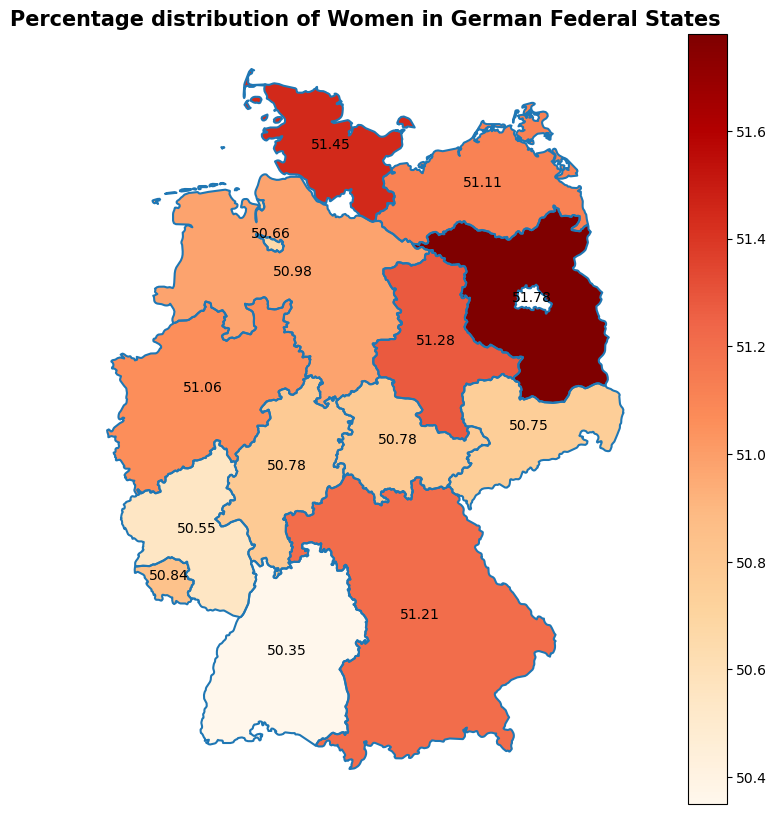

In [98]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

#exra stuff-------------------------------
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
#------------------------------------------


# result gets  transformed so the 'umlaute' are no longer a problem for the .shp / .dbf file
def replace_german_characters(text):
    replacements = {
        'ä': 'ae', 'ö': 'oe','ü': 'ue','Ä': 'Ae','Ö': 'Oe','Ü': 'Ue','ß': 'ss'
    }
    
    for german_char, replacement in replacements.items():
        text = text.replace(german_char, replacement)
    
    return text
data=[(replace_german_characters(state), count,count2, round(percentage,2)) for state, count,count2, percentage in result]

# Create a DATAFRAME 
df = pd.DataFrame(data, columns=['State', 'Value','Value2','Percentages'])

# Load the shapefile of Germany's federal states
gdf = gpd.read_file("/home/maxim/Documents/DBS_project/de_shp/de.shp") #DONT FORGET CHANGE THE PATH!!


# statenames -> 'name' (in .dbf file!!)
gdf = gdf.merge(df, left_on='name', right_on='State')

# MAP Plotting for the .shp file
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.boundary.plot(ax=ax)
gdf.plot(column='Percentages', ax=ax, legend=True, cmap='OrRd')


for idx, row in gdf.iterrows():
    plt.annotate(text=row['Percentages'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=10, color='black')

ax.set_title('Percentage distribution of Women in German Federal States', fontsize=15, fontweight='bold')

ax.set_axis_off()

# PLOT
plt.show()

#CHECKING for testing
#print("GeoDataFrame 'name' column values:")
#print(gdf['name'].unique())

#print("\nDataFrame 'State' column values:")
#print(df['State'].unique())

Visualizing Query3

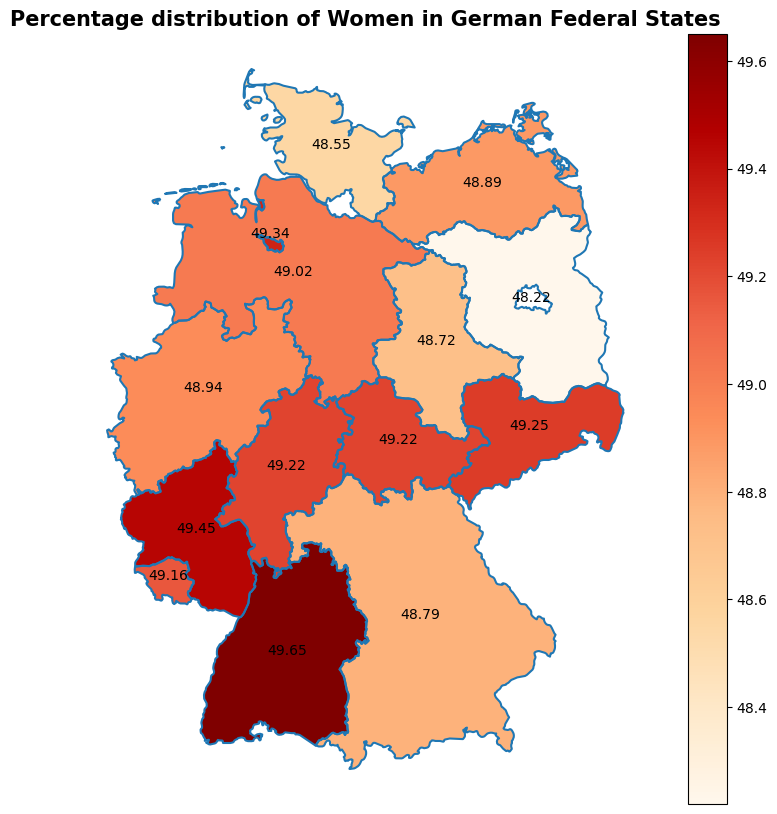

In [99]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

#exra stuff-------------------------------
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
#------------------------------------------


# result3 gets  transformed so the 'umlaute' are no longer a problem for the .shp / .dbf file
def replace_german_characters(text):
    replacements = {
        'ä': 'ae', 'ö': 'oe','ü': 'ue','Ä': 'Ae','Ö': 'Oe','Ü': 'Ue','ß': 'ss'
    }
    
    for german_char, replacement in replacements.items():
        text = text.replace(german_char, replacement)
    
    return text
data=[(replace_german_characters(state), count,count2, round(percentage,2)) for state, count,count2, percentage in result3]

# Create a DATAFRAME 
df = pd.DataFrame(data, columns=['State', 'Value','Value2','Percentages'])

# Load the shapefile of Germany's federal states
gdf = gpd.read_file("/home/maxim/Documents/DBS_project/de_shp/de.shp") #DONT FORGET CHANGE THE PATH!!


# statenames -> 'name' (in .dbf file!!)
gdf = gdf.merge(df, left_on='name', right_on='State')

# MAP Plotting for the .shp file
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.boundary.plot(ax=ax)
gdf.plot(column='Percentages', ax=ax, legend=True, cmap='OrRd')


for idx, row in gdf.iterrows():
    plt.annotate(text=row['Percentages'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=10, color='black')

ax.set_title('Percentage distribution of Women in German Federal States', fontsize=15, fontweight='bold')

ax.set_axis_off()

# PLOT
plt.show()

#CHECKING for testing
#print("GeoDataFrame 'name' column values:")
#print(gdf['name'].unique())

#print("\nDataFrame 'State' column values:")
#print(df['State'].unique())

Visualizing Query2

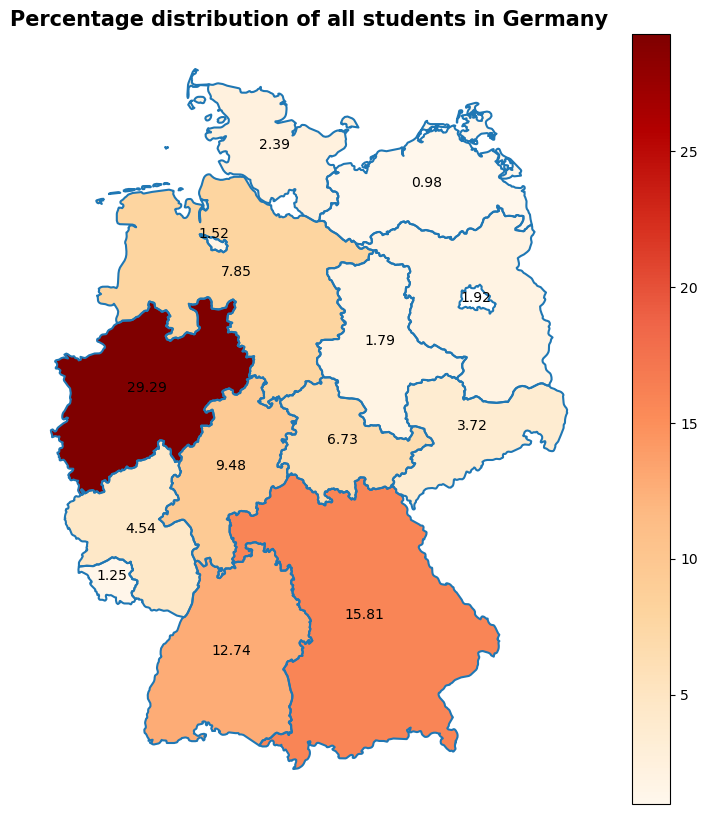

In [56]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

#exra stuff-------------------------------
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
#------------------------------------------


# result2 gets  transformed so the 'umlaute' are no longer a problem for the .shp / .dbf file
def replace_german_characters(text):
    replacements = {
        'ä': 'ae', 'ö': 'oe','ü': 'ue','Ä': 'Ae','Ö': 'Oe','Ü': 'Ue','ß': 'ss'
    }
    
    for german_char, replacement in replacements.items():
        text = text.replace(german_char, replacement)
    
    return text
data=[(replace_german_characters(state), count, round(percentage,2)) for state, count, percentage in result2]

# Create a DATAFRAME 
df = pd.DataFrame(data, columns=['State', 'Value','Percentages'])

# Load the shapefile of Germany's federal states
gdf = gpd.read_file("/home/maxim/Documents/DBS_project/de_shp/de.shp") #DONT FORGET CHANGE THE PATH!!


# statenames -> 'name' (in .dbf file!!)
gdf = gdf.merge(df, left_on='name', right_on='State')

# MAP Plotting for the .shp file
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.boundary.plot(ax=ax)
gdf.plot(column='Percentages', ax=ax, legend=True, cmap='OrRd')


for idx, row in gdf.iterrows():
    plt.annotate(text=row['Percentages'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=10, color='black')

ax.set_title('Percentage distribution of all students in Germany', fontsize=15, fontweight='bold')

ax.set_axis_off()

# PLOT
plt.show()

#CHECKING for testing
#print("GeoDataFrame 'name' column values:")
#print(gdf['name'].unique())

#print("\nDataFrame 'State' column values:")
#print(df['State'].unique())

Visualizing Query4

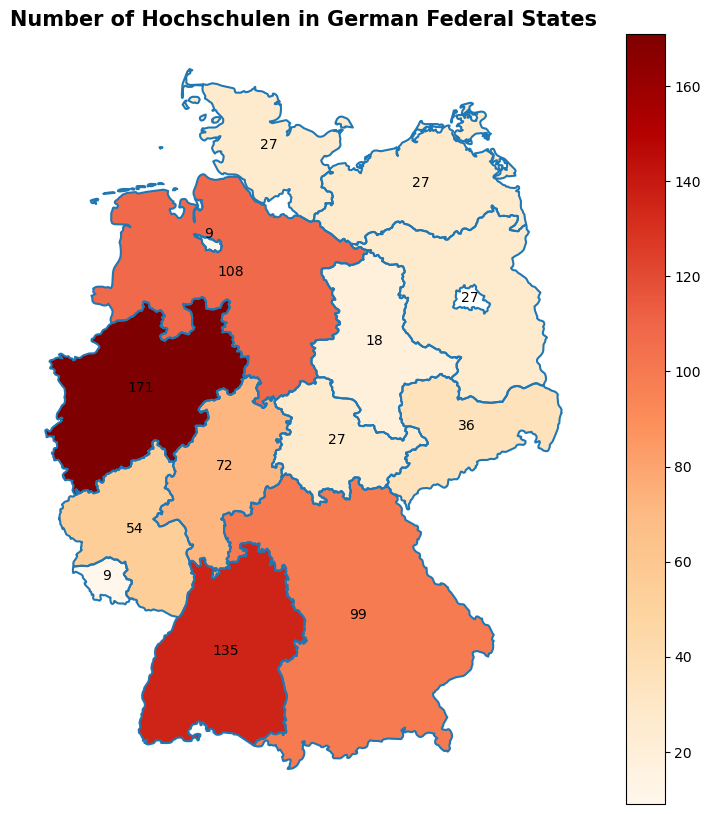

In [68]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

#exra stuff-------------------------------
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
#------------------------------------------

# result4 gets  transformed so the 'umlaute' are no longer a problem for the .shp / .dbf file
data = [(s.replace('ü','ue'),n) for s, n in result7]


# Create a DATAFRAME 
df = pd.DataFrame(data, columns=['State', 'Value'])

# Load the shapefile of Germany's federal states
gdf = gpd.read_file("/home/maxim/Documents/DBS_project/de_shp/de.shp") #DONT FORGET CHANGE THE PATH!!


# statenames -> 'name' (in .dbf file!!)
gdf = gdf.merge(df, left_on='name', right_on='State')

# MAP Plotting for the .shp file
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.boundary.plot(ax=ax)
gdf.plot(column='Value', ax=ax, legend=True, cmap='OrRd')

for idx, row in gdf.iterrows():
    plt.annotate(text=row['Value'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=10, color='black')

ax.set_title('Number of Hochschulen in German Federal States', fontsize=15, fontweight='bold')

ax.set_axis_off()

#plot
plt.show()

#CHECKING for testing
#print("GeoDataFrame 'name' column values:")
#print(gdf['name'].unique())

#print("\nDataFrame 'State' column values:")
#print(df['State'].unique())

Visualizing Query6

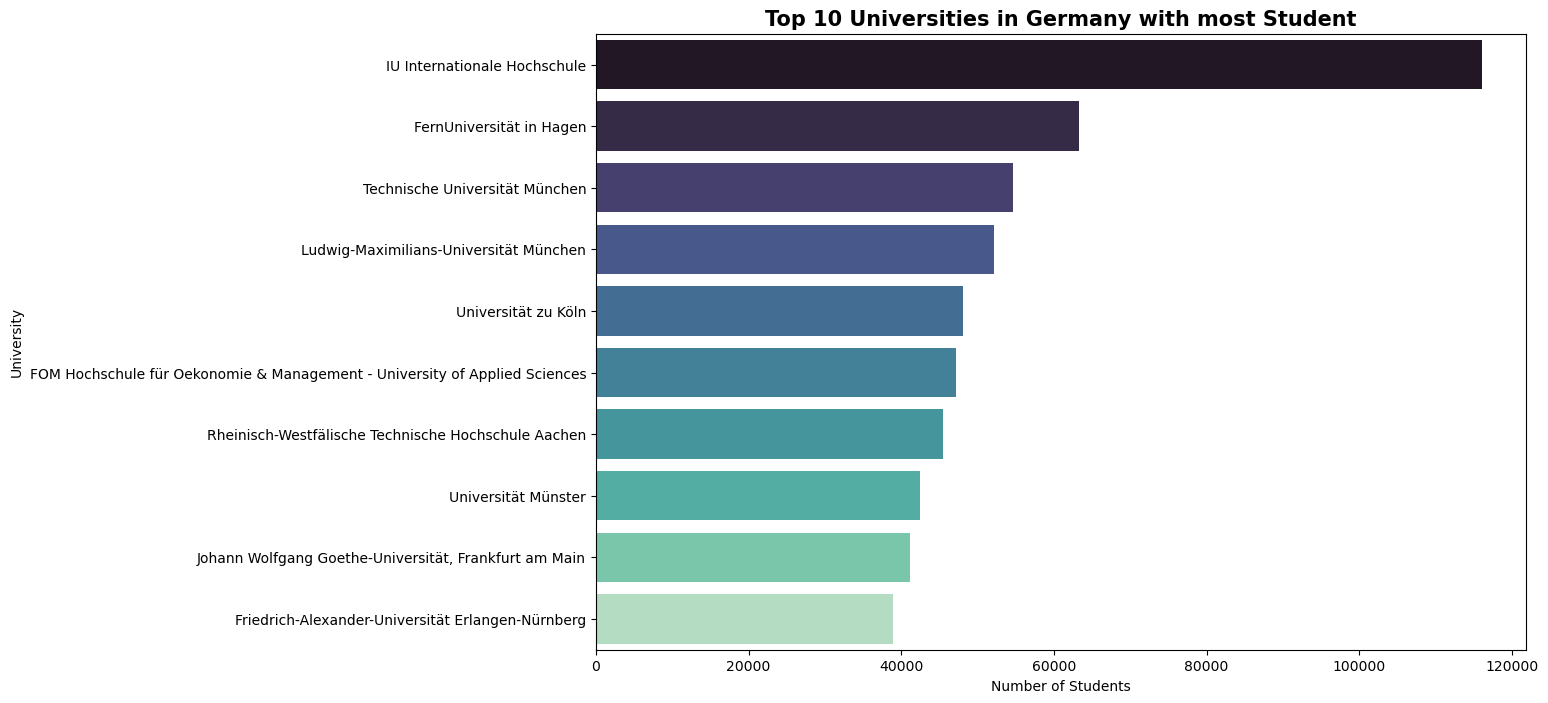

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(result6, columns=['University', 'Students', 'Location'])

# PLOTTING
plt.figure(figsize=(12, 8))
sns.barplot(y='University', x='Students', data=df, palette='mako',legend=False,hue='University')
plt.title('Top 10 Universities in Germany with most Student', fontsize=15, fontweight='bold')
plt.xlabel('Number of Students')
plt.ylabel('University')
plt.show()


Visualizing Query5

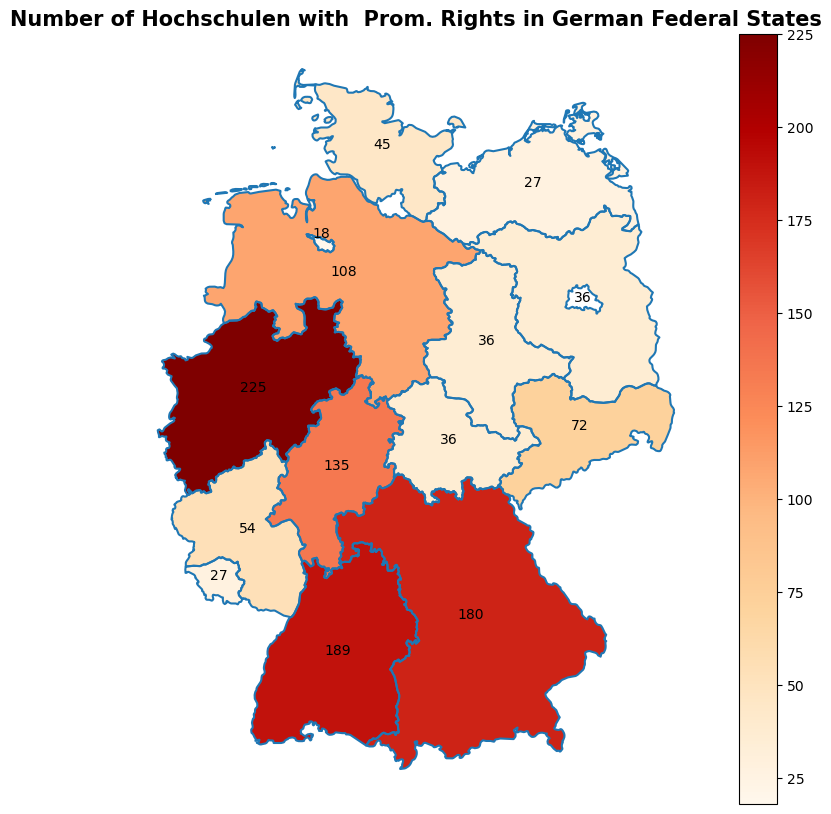

In [73]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

#exra stuff-------------------------------
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
#------------------------------------------

# result5 gets  transformed so the 'umlaute' are no longer a problem for the .shp / .dbf file
data = [(s.replace('ü','ue'),n) for s, n in result5]


# Create a DATAFRAME 
df = pd.DataFrame(data, columns=['State', 'Value'])

# Load the shapefile of Germany's federal states
gdf = gpd.read_file("/home/maxim/Documents/DBS_project/de_shp/de.shp") #DONT FORGET CHANGE THE PATH!!


# statenames -> 'name' (in .dbf file!!)
gdf = gdf.merge(df, left_on='name', right_on='State')


# MAP Plotting for the .shp file
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.boundary.plot(ax=ax)
gdf.plot(column='Value', ax=ax, legend=True, cmap='OrRd')


for idx, row in gdf.iterrows():
    plt.annotate(text=row['Value'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=10, color='black')

ax.set_title('Number of Hochschulen with  Prom. Rights in German Federal States', fontsize=15, fontweight='bold')

ax.set_axis_off()

# plot
plt.show()

#CHECKING for testing
#print("GeoDataFrame 'name' column values:")
#print(gdf['name'].unique())

#print("\nDataFrame 'State' column values:")
#print(df['State'].unique())

Visualizing Query7

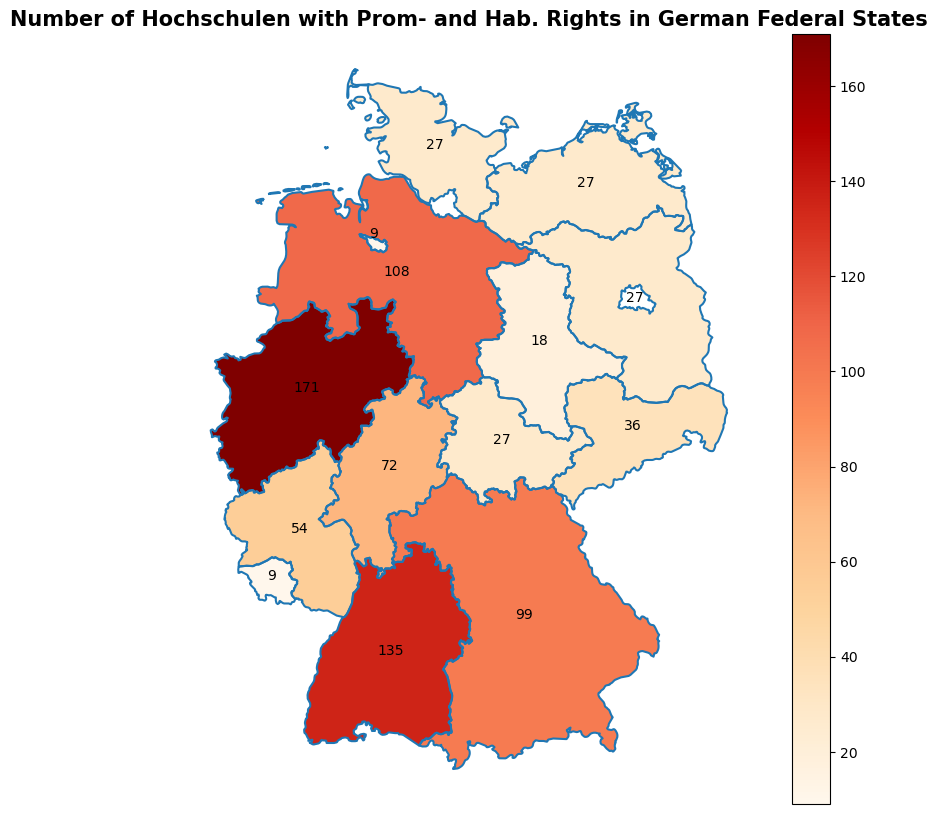

In [45]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

#exra stuff-------------------------------
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
#------------------------------------------

# result7 gets  transformed so the 'umlaute' are no longer a problem for the .shp / .dbf file
data = [(s.replace('ü','ue'),n) for s, n in result7]


# Create a DATAFRAME 
df = pd.DataFrame(data, columns=['State', 'Value'])

# Load the shapefile of Germany's federal states
gdf = gpd.read_file("/home/maxim/Documents/DBS_project/de_shp/de.shp") #DONT FORGET CHANGE THE PATH!!


# statenames -> 'name' (in .dbf file!!)
gdf = gdf.merge(df, left_on='name', right_on='State')


# MAP Plotting for the .shp file
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.boundary.plot(ax=ax)
gdf.plot(column='Value', ax=ax, legend=True, cmap='OrRd')


for idx, row in gdf.iterrows():
    plt.annotate(text=row['Value'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=10, color='black')

ax.set_title('Number of Hochschulen with Prom- and Hab. Rights in German Federal States', fontsize=15, fontweight='bold')

ax.set_axis_off()

# plot
plt.show()

#CHECKING for testing
#print("GeoDataFrame 'name' column values:")
#print(gdf['name'].unique())

#print("\nDataFrame 'State' column values:")
#print(df['State'].unique())

## Task 8: Additional task for 7 CP students

### Task 8.1: 
Integrate information from at least one publicly available additional demographic data set
(e.g., average age, average income, unemployment rate) into the visualization concept. Provide
a brief description of how this data enhances your analysis.

### Task 8.2:
Implement advanced sorting and filter functions, which are applied on the result set of your
queries. For example, implement functions that allow sorting by different criteria and filtering
based on specific conditions.
